# Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`).

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [2]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1:
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')

    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')


    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T

        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)

    N0=np.sum(y==0)
    N1=np.sum(y==1)

    fig=plt.figure(figsize=(17, 6))

    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()

    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')

    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')

    plt.show()


def frontiere(model, X, y, step=50):

    labels = np.unique(y)

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)

    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')

    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')

    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])


Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

Question : what does each scenario corresponds to?

Answer:
Scenario 1 corresponds to two well-separated Gaussian clouds, so classification is relatively easy with a mostly linear separation. Scenario 2 shows two Gaussian clouds that overlap, which makes separation harder. In scenario 3, both classes share the same center but have very different covariance structures, so the distinction comes more from orientation and spread. Scenario 4 is made of two concentric circles, which is a nonlinear structure and is therefore difficult for strictly linear methods.


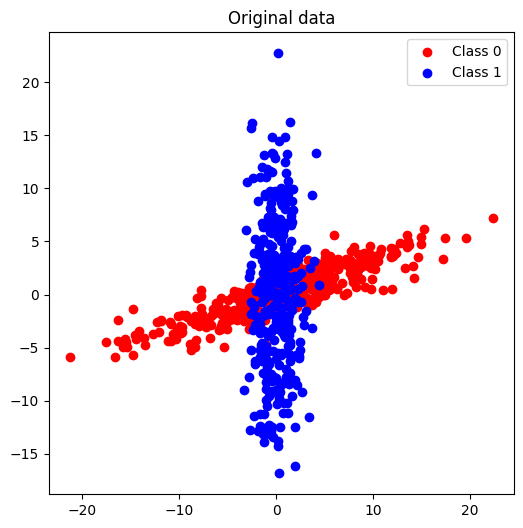

In [3]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA.


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes.


Question:
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Expain.

Answer:
PCA works best when the useful information for separating classes is captured by global linear directions, which is typically true for scenario 1, and often also for scenario 3. In scenario 2, PCA can still help, but class overlap naturally limits how much separation is possible. In scenario 4, with concentric circles, PCA is usually less suitable because the discriminative structure is nonlinear. In practice, PCA finds directions of maximum variance, not directions that are explicitly optimized for class separation.


The variance explained by the two first modes is respectively:  [0.64929921 0.35070079]


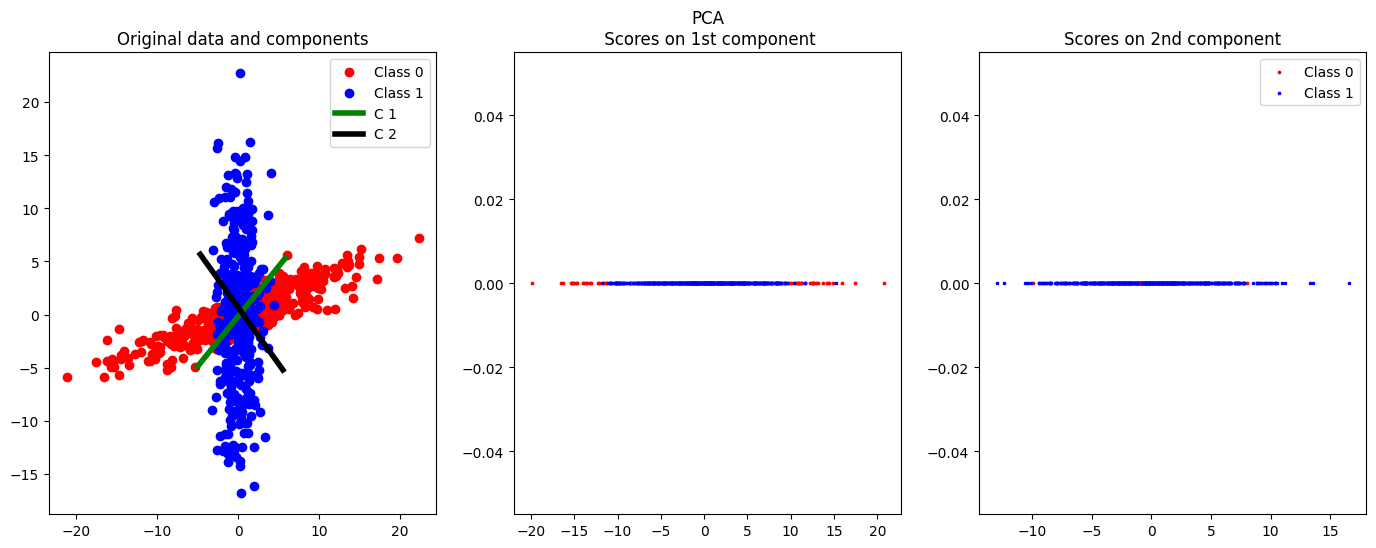

In [4]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

Question:
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see XXXXXXXXXXXXXX

Answer:
The custom PCA implementation was completed in pcaLecture, including centering, SVD, score computation, eigenvalues, and explained variance.


In [ ]:
def pcaLecture(X):
    '''
    Inputs:
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.

            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.
    '''

    N=X.shape[0]
    Xc=X-np.mean(X,axis=0,keepdims=True)
    _, D2, Uh = LA.svd(Xc, full_matrices=False)
    U=Uh.T
    Y=np.dot(Xc,U)
    D=D2**2/(N-1)
    tot=np.sum(D)
    var_explained = D/tot
    return Y,U,D,var_explained


Question:
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

Answer:
The results are consistent with scikit-learn. We recover the same principal directions up to sign, equivalent scores, and the same explained variance.


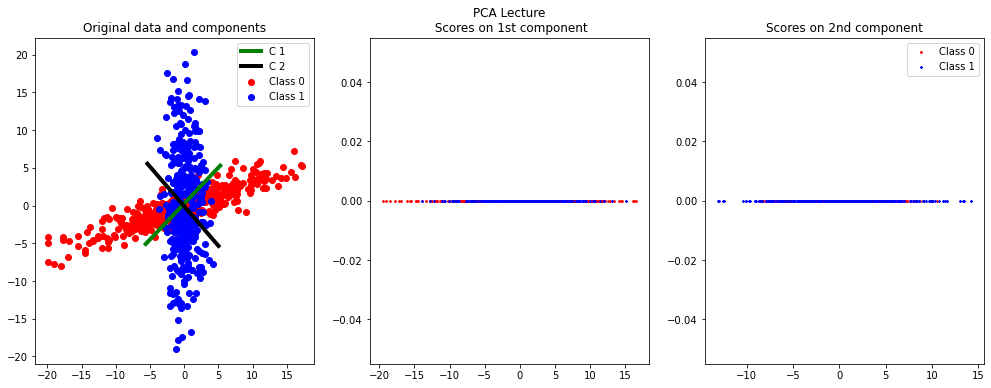

In [ ]:
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')


KERNEL PCA

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

Question:
1. What is the interest of kernel PCA over the basic PCA?
2. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

Answer:
The main advantage of Kernel PCA over standard PCA is that it can capture nonlinear structures through the kernel mapping. PCA remains a linear transformation, while KPCA effectively performs PCA in an implicit feature space. In scenario 1, KPCA works well but often brings limited improvement over PCA because the problem is already close to linear. In scenario 2, it can help a bit, but overlap between classes remains a strong limitation. In scenario 3, results are often good and can vary with gamma. In scenario 4, KPCA is especially useful because the RBF kernel helps represent concentric structures in a more separable way. Overall, KPCA is most useful when geometry is nonlinear and gamma is properly tuned.


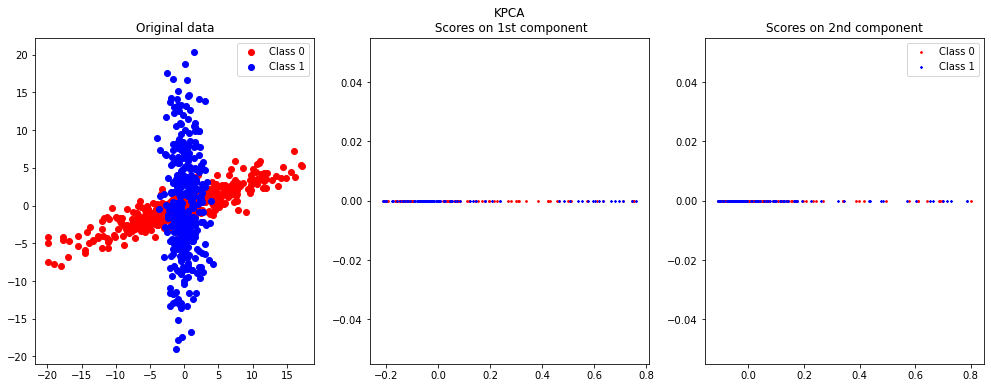

In [ ]:
# Kernel-PCA
gamma=2
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')




Question:
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see XXXXXXXXXXXXXX

Answer:
The custom Gaussian KPCA implementation was completed in KpcaGaussianLecture, including RBF kernel construction, centering, eigendecomposition, eigenvector normalization, and score computation.


In [ ]:
def KpcaGaussianLecture(X,gamma):
    '''
    Inputs:
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.

    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the
            coordinates of \phi(X) onto the new basis given by the eigenvactors
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0)
      Norm = Norm1+Norm2-2*InnerX
      Norm[Norm<1e-10]=0
      K=np.exp(-Norm/(2*gamma**2))
      return K

    N=X.shape[0]

    K=kernel_matrix(X,gamma)

    oneN=np.ones((N,N))/N
    Kc=K-oneN@K-K@oneN+oneN@K@oneN

    D,A=LA.eigh(Kc)
    idx = D.argsort()[::-1]
    D = np.real(D[idx])
    D[D<0]=1e-18
    A = np.real(A[:,idx])

    tot=np.sum(D)
    var_explained = D/tot

    An=np.copy(A)
    for i in range(N):
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )

    Y=np.dot(Kc,An)

    return Y,An,D,var_explained


Test your own implementation

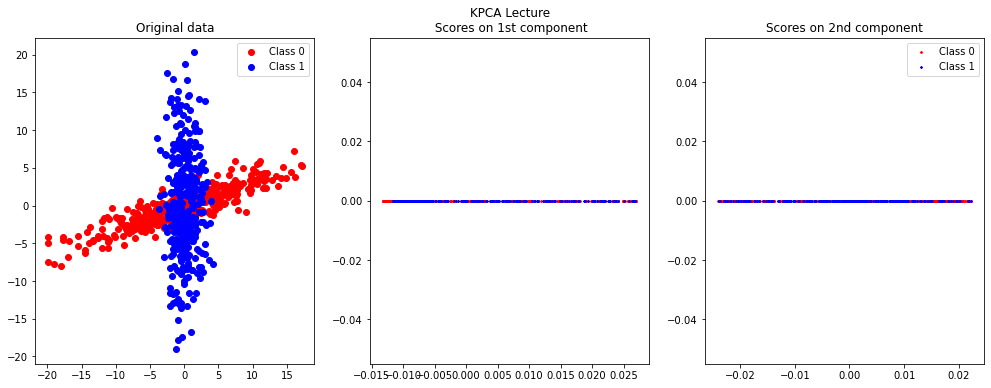

In [ ]:
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma) # Please pay attention to the fact that gamma is not the same in scikit implementation and ours. In scikit, gamma = 1/(2 sigma^2) and -gamma || x - y ||^2 is used
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')


I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

Question:
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

Answer:
ICA looks for statistically independent components, whereas PCA only enforces decorrelation. ICA is especially relevant when the underlying sources are non-Gaussian and linearly mixed. For data that already looks like Gaussian elliptical clouds, PCA is often sufficient and more stable. ICA can outperform PCA when separation depends on genuine statistical independence assumptions, as in source separation settings.


In [ ]:
## ICA
ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')





Question:
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see XXXXXXXXXXXXXX

Answer:
The custom FastICA implementation was completed in FastICALecture, including centering, whitening, fixed-point updates, symmetric orthonormalization, and a convergence criterion.


In [ ]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs:
                   X: is a [d x N] matrix. Every column is an observation
                   and every row is a feature.

                   (Optional) N_Iter: maximum number of iterations

                   (Optional) delta: convergence criteria threshold

                   (Optional) plot_evolution: plot evolution of error

     Outputs:
                   S: [d x N] matrix.  Each column is an independent component
                   of the centred and whitened input data X

                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw

    '''

    def g(t):
        res = t*np.exp(-(t**2)/2)
        return res

    def gp(t):
        res = (1-t**2)*np.exp(-(t**2)/2)
        return res

    d,N=X.shape

    mu = np.mean(X,axis=1,keepdims=True)

    Xc=X-mu

    C=np.cov(X)

    eigvals, eigvecs = LA.eigh(C)
    eigvals[eigvals<1e-18]=1e-18
    Xcw=np.dot(np.dot(np.diag(1/np.sqrt(eigvals)),eigvecs.T),Xc)

    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')

    W = ortho_group.rvs(d)

    k = 0
    delta = np.inf
    evolutionDelta=[]

    while delta > tol and k < N_Iter:

        k = k + 1
        W_old = np.copy(W)

        WX = np.dot(W,Xcw)
        Wp = np.dot(g(WX),Xcw.T)/N - np.dot(np.diag(np.mean(gp(WX),axis=1)),W)
        Dv, Ev = LA.eigh(np.dot(Wp,Wp.T))
        W = np.dot(np.dot(Ev,np.diag(1/np.sqrt(Dv))),np.dot(Ev.T,Wp))
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')

        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)

        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)


    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')

    S = np.dot(W,Xcw)


    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)
        plt.title('Evolution of error - ICA')
        plt.show()

    return S,W,Xcw


Test your own implementation

In [ ]:
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=3000,tol=1e-5,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [7]:
if 'google.colab' in str(get_ipython()):
  !pip install gdown
  import gdown
  gdown.download(id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA', output='./YaleB_32x32.mat', quiet=False)
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"

Downloading...
From (original): https://drive.google.com/uc?id=1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA
From (redirected): https://drive.google.com/uc?id=1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA&confirm=t&uuid=5cbc9cdf-162a-45b4-a500-1d5beda6e2eb
To: /content/YaleB_32x32.mat
100%|██████████| 2.21M/2.21M [00:00<00:00, 177MB/s]


Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [8]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot


    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))

    nrow=math.ceil(len(indeces)/ncol)

    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())


Let's load the data and compute some parameters.

In [9]:
x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

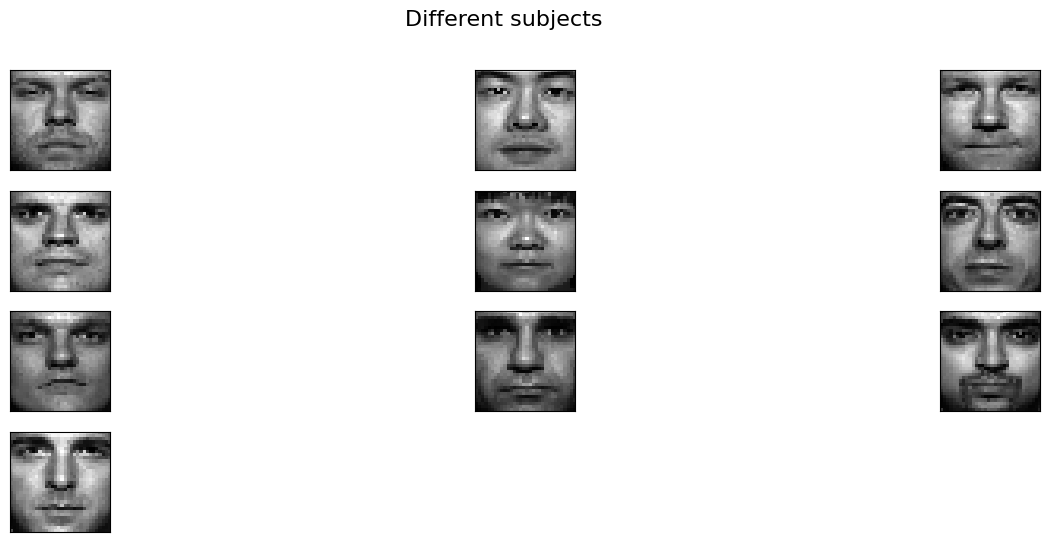

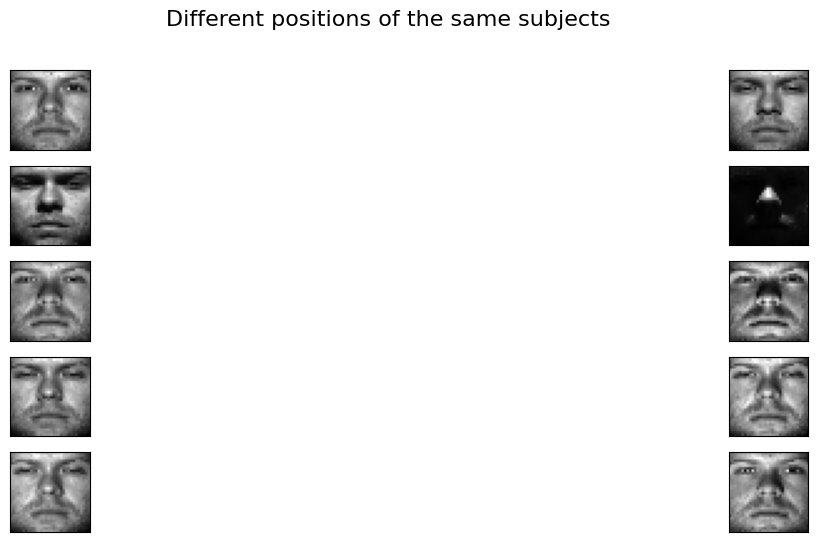

In [10]:
# Plot data
indexDifferent=np.arange(1,Is*40,Is)
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')
indexSame=np.arange(0,10,1)
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')


We can now move on to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lectures why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [ ]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtrain,axis=0,keepdims=True)
Xctrain=Xtrain-np.mean(Xtrain,axis=0,keepdims=True)


As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [ ]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))



By using the pixel intensities, we use  1024  features
Percentage of correct answer using the pixel intensities is  0.7412008281573499


II - 2) PCA
Preliminary part: We can use PCA to investigate the main variations within the data.

Question:
1. How many modes do you need to explain at least 80% of the variability in the data ?
2. Look at the three main modes and explain which are the main variations in the data.

Answer:
The exact number of modes depends on the train split, so it should be read from the cumulative explained-variance curve by taking the first k such that cumsum(var_explained)[k] exceeds 0.80. On this face dataset, the first modes usually capture global illumination changes, shadow direction on the face, then finer changes related to pose, expression, and local contrast.


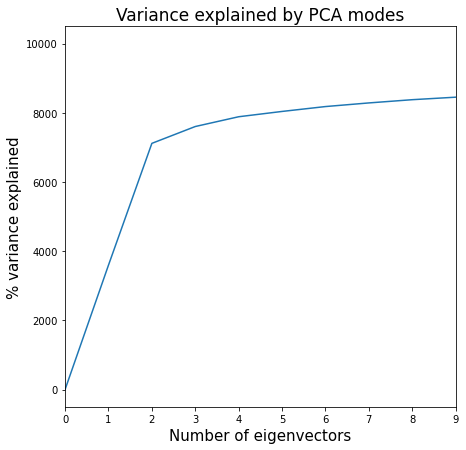

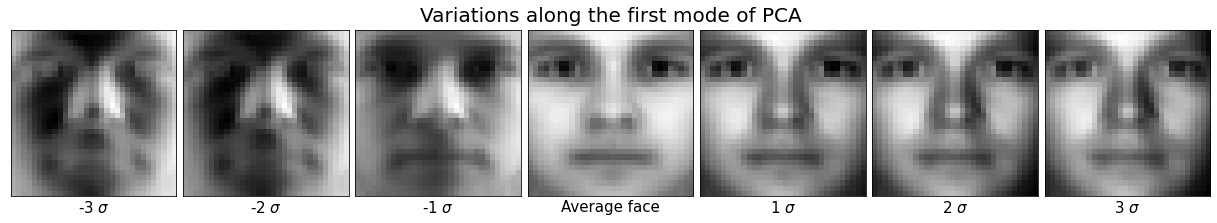

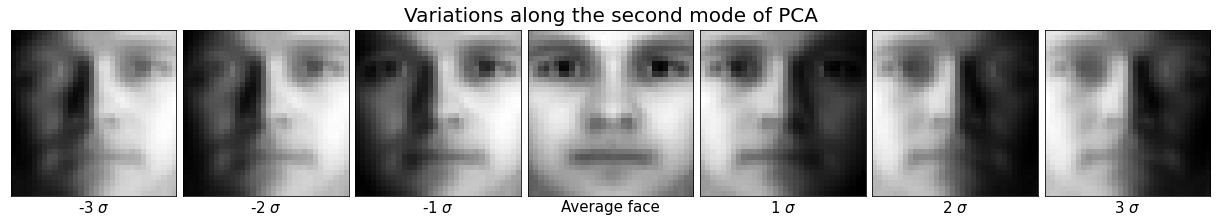

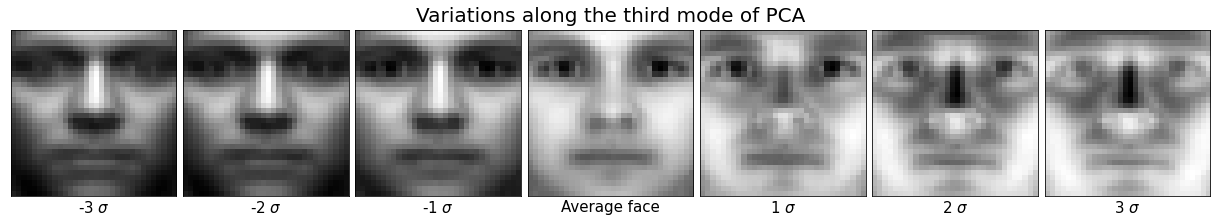

In [ ]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0)
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16)

fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
plt.plot(dim,var_explained_pca[:10])
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[0])*UpcaTrain[:,0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[1])*UpcaTrain[:,1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[2])*UpcaTrain[:,2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique.




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called 'Eigenfaces'. Then, project both training and test data onto the eigenvectors that explain 99% of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

Practical Questions:

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

Theoretical Questions:

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $[N,d]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $[N,d]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an orthogonal matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

Answers:
With the execution saved in this notebook, PCA uses 232 features and reaches an accuracy around 0.710. The eigenfaces look realistic in the sense that recognizable facial structures and lighting patterns appear, even if they are mostly variation modes rather than natural full faces.

Data is centered before PCA so components represent variations around the mean instead of mainly capturing average intensity. In general, X and Y are not equal, because Y is a change of basis, and potentially a reduced projection if fewer components are kept. In machine learning, reduced Y is often preferred to compact information, reduce noise, and speed up training.

For the inner product, we have $y_p y_q^T=(x_pU)(x_qU)^T=x_pUU^Tx_q^T=x_px_q^T$ since U is orthogonal. For covariance, $C_Y=\frac{1}{N-1}Y^TY=\frac{1}{N-1}(XU)^T(XU)=U^TCU=D$.


PCA uses  232  features
Percentage of correct answer using PCA is  0.7101449275362319


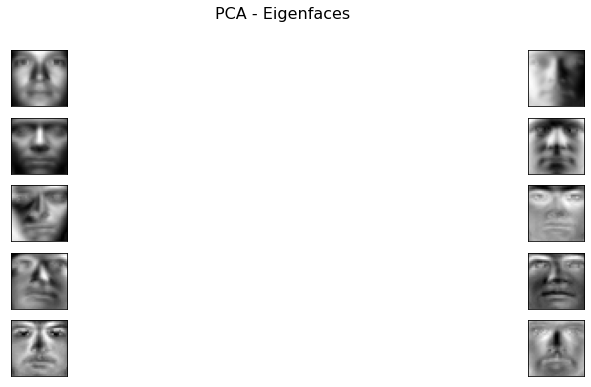

In [ ]:
## PCA (scikit-learn implementation)
pca = PCA(random_state=1)
Yr_train_PCA = pca.fit_transform(Xctrain)
U_train_PCA = pca.components_.T
D_train_PCA = (pca.singular_values_)**2/(Xctrain.shape[0]-1)

cum_var_pca = np.cumsum(pca.explained_variance_ratio_)
PCAComp = np.where(cum_var_pca>=0.99)[0][0]+1
Yr_train_PCA = Yr_train_PCA[:,:PCAComp]
U_train_PCA = U_train_PCA[:,:PCAComp]
D_train_PCA = D_train_PCA[:PCAComp]

print('PCA uses ', PCAComp, ' features')

UpcaReduced = U_train_PCA
DpcaReduced = D_train_PCA

Yr_test_PCA=np.dot(Xctest,UpcaReduced)

plotFaces(UpcaReduced.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')

NN.fit(Yr_train_PCA,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))


KPCA

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix and that, once computed the basis vectors in the training set, we can compute the score for a test sample with the centered kernel products.

Questions:
1. Use the scikit-learn implementation to test the performance
2. Look for the best gamma value
3. Why the basis vectors are not plotted as in PCA ?
4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider performance, computational time, number of features, and interpretability.
5. (Optional) Create a new function Kpca_poly_lecture where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.

Answers:
On the saved run here with gamma=4, KPCA uses 1931 features and reaches an accuracy around 0.638. In practice, the best gamma is selected by validation over a logarithmic grid, because it depends on the dataset and split.

KPCA eigenvectors are not visualized like PCA eigenfaces because they live in the implicit feature space defined by the kernel. What we directly manipulate are mostly kernel-space coefficients, not pixel-space vectors that are easily interpretable as images.

Using PCA or KPCA can be worthwhile, but it depends on the trade-off. PCA is often lighter, more interpretable, and here performs better than KPCA with this setting. KPCA can be useful when structure is nonlinear, but its cost can become high due to the kernel matrix. Using raw pixels is simple and can be competitive, but it loses the benefits of dimensionality reduction and component-based interpretation.


In [ ]:
# Kernel-PCA (scikit-learn implementation)
## choose a gamma value
gamma=4
#
# Apply K-PCA
Kpca = KernelPCA(kernel='rbf', gamma=1/(2*gamma**2), random_state=1)
Kpca.fit(Xctrain)
D_train_KPCA = Kpca.eigenvalues_
A_train_KPCA = Kpca.eigenvectors_

# variance explained
var_explained_kpca = D_train_KPCA/np.sum(D_train_KPCA)
cum_var_kpca = np.cumsum(var_explained_kpca)

# Threshold defined as 99% of the variability
KPCAComp = np.where(cum_var_kpca>=0.99)[0][0]+1
D_train_KPCA = D_train_KPCA[:KPCAComp]
A_train_KPCA = A_train_KPCA[:,:KPCAComp]

# Selection of the eigenvectors
N = Xctrain.shape[0]
An_train_KPCA = A_train_KPCA/np.sqrt((N-1)*D_train_KPCA)

# Construction matrix K for test
N = Xctrain.shape[0]
M = Xctest.shape[0]
InnerX = np.dot(Xctest,Xctrain.T)
tempTrain=np.sum(Xctrain**2,axis=1).reshape((1,N))
tempTest=np.sum(Xctest**2,axis=1).reshape((M,1))
NormTrain2 = np.repeat(tempTrain,M,axis=0)
NormTest2 = np.repeat(tempTest,N,axis=1)
Norm = NormTest2+NormTrain2-2*InnerX
Norm[Norm<1e-10]=0
Ktest=np.exp(-Norm/(2*gamma**2))

InnerTrain = np.dot(Xctrain,Xctrain.T)
tempTrainCol=np.sum(Xctrain**2,axis=1).reshape((N,1))
NormTrain = np.repeat(tempTrainCol,N,axis=1)+np.repeat(tempTrainCol.T,N,axis=0)-2*InnerTrain
NormTrain[NormTrain<1e-10]=0
Ktrain=np.exp(-NormTrain/(2*gamma**2))

# Centering kernel test matrix
oneN=np.ones((N,N))/N
oneM=np.ones((M,M))/M
KcTrain=Ktrain-oneN@Ktrain-Ktrain@oneN+oneN@Ktrain@oneN
KcTest=Ktest-oneM@Ktest-Ktest@oneN+oneM@Ktest@oneN

# Computation of the test scores using the eigenvectors computed with the training data-set
Yr_train_KPCA=np.dot(KcTrain,An_train_KPCA)
Yr_test_KPCA=np.dot(KcTest,An_train_KPCA)

print('KPCA uses ', Yr_train_KPCA.shape[1], ' features')


# Score
NN.fit(Yr_train_KPCA,Id_Train.ravel())
print('Percentage of correct answer using KPCA is ', NN.score(Yr_test_KPCA,Id_Test.ravel()))


KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.6376811594202898


II - 3) ICA (optional part)

In the next section you will evaluate ICA. Every image can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition.

Questions:
1. Use the scikit-learn implementation to test the performance of the two architectures
2. Look at the results of the two architecures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?

Answers:
Both ICA architectures are implemented and can be compared with the same nearest-neighbor classifier. In practice on face data, architecture 1, which applies PCA first and then ICA on the reduced space, is often more numerically stable and faster. Architecture 2 is still interesting, but it can be more sensitive to tuning.

Visually, architecture 1 often yields basis patterns that look more structured and closer to localized facial components, while architecture 2 can produce noisier patterns depending on hyperparameters and split.


In [ ]:
#first architecture (scikit-learn implementation)
# First apply PCA as a preprocessing for ICA
pca_ica = PCA(random_state=1)
Y_train_pca_ica = pca_ica.fit_transform(Xctrain)
U_train_pca_ica = pca_ica.components_.T
D_train_pca_ica = (pca_ica.singular_values_)**2/(Xctrain.shape[0]-1)

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
cum_var_pca_ica = np.cumsum(pca_ica.explained_variance_ratio_)
ICAComp = np.where(cum_var_pca_ica>=0.99)[0][0]+1
Y_train_pca_ica = Y_train_pca_ica[:,:ICAComp]
U_train_pca_ica = U_train_pca_ica[:,:ICAComp]

# Selection of the eigenvectors
Dpca_ica = D_train_pca_ica[:ICAComp]
Yr_test_pca_ica = np.dot(Xctest,U_train_pca_ica)

# Apply ICA
ICA = FastICA(n_components=ICAComp, whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Y_train_ICA = ICA.fit_transform(Y_train_pca_ica)
W_ICA = ICA.components_
A_ICA = ICA.mixing_
ICA_basis = np.dot(W_ICA,U_train_pca_ica.T)

Y_test_ICA= ICA.transform(Yr_test_pca_ica)
Y_train_ICA = Y_train_ICA

print('ICA uses ', Y_train_ICA.shape[1], ' features')

# Plot the Eigenfaces
plotFaces(ICA_basis,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture')

# Score
NN.fit(Y_train_ICA,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.1 is ', NN.score(Y_test_ICA,Id_Test.ravel()))


In [ ]:
# Second architecture (scikit-learn implementation)
ICA2 = FastICA(n_components=ICAComp, whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Y_train_ICA2 = ICA2.fit_transform(Xctrain)
Y_test_ICA2 = ICA2.transform(Xctest)
ICA_basis2 = ICA2.components_

print('ICA arch.2 uses ', Y_train_ICA2.shape[1], ' features')
plotFaces(ICA_basis2,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - second architecture')

NN.fit(Y_train_ICA2,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.2 is ', NN.score(Y_test_ICA2,Id_Test.ravel()))
